In [42]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Color theme for visualizations
JAPAN_RED = '#C1272D'
JAPAN_WHITE = '#FFFFFF'
CHARCOAL = '#2C2C2C'
LIGHT_GREY = '#F5F5F5'
ACCENT_RED = '#D91E10'

In [4]:
# Plotting Parameters for visualizations
plt.rcParams['figure.facecolor'] = LIGHT_GREY
plt.rcParams['axes.facecolor'] = JAPAN_WHITE
plt.rcParams['axes.edgecolor'] = CHARCOAL
plt.rcParams['xtick.color'] = CHARCOAL
plt.rcParams['ytick.color'] = CHARCOAL
plt.rcParams['text.color'] = CHARCOAL
plt.rcParams['grid.color'] = '#E0E0E0'
plt.rcParams['grid.alpha'] = 0.5

In [29]:
# Loading the data file
df = pd.read_csv('japan_data.csv',index_col = 0, parse_dates=True)
df.head()

,GDP_per_capita,Consumption_per_capita
Year,,
1974-01-01,4448.319656,2110.683134
1975-01-01,4775.899536,2384.062416
1976-01-01,5310.431409,2667.407194
1977-01-01,6472.787787,3262.015600
1978-01-01,9012.136035,4542.051021


In [30]:
# Basic Exploratory Data Analysis - Shape of the dataset
print(f"Shape of the dataset is {df.shape}")

Shape of the dataset is (49, 2)


In [31]:
# Basic Exploratory Data Analysis - Columns
print(f"The columns are: {list(df.columns)}")

The columns are: ['GDP_per_capita', 'Consumption_per_capita']


In [32]:
# Basic Exploratory Data Analysis - Range of dates
print(f"Year Range: {df.index[0].strftime('%Y')} to {df.index[-1].strftime('%Y')}")

Year Range: 1974 to 2022


In [33]:
# Calculation of growth rates
# Growth rate = ((X_t - X_t-1) / (X_t-1)) * 100
df['GDP_growth'] = df['GDP_per_capita'].pct_change() * 100
df['Consumption_growth'] = df['Consumption_per_capita'].pct_change() * 100

In [18]:
# Remove the NaN values
df_growth = df[['GDP_growth','Consumption_growth']].dropna()
df_growth.head()

,GDP_growth,Consumption_growth
Year,,
1975-01-01,7.364126,12.952171
1976-01-01,11.192276,11.884956
1977-01-01,21.888172,22.291625
1978-01-01,39.231137,39.240628
1979-01-01,3.206923,5.043940


In [34]:
# Descriptive statistics for the growth dataframe
df_growth.describe()

,GDP_growth,Consumption_growth
count,48.000000,48.000000
mean,4.993866,5.326359
std,12.257339,12.175036
min,-16.780111,-16.117369
25%,-1.295644,-1.609774
50%,4.583284,4.880239
75%,10.074056,11.001770
max,47.778429,46.828434


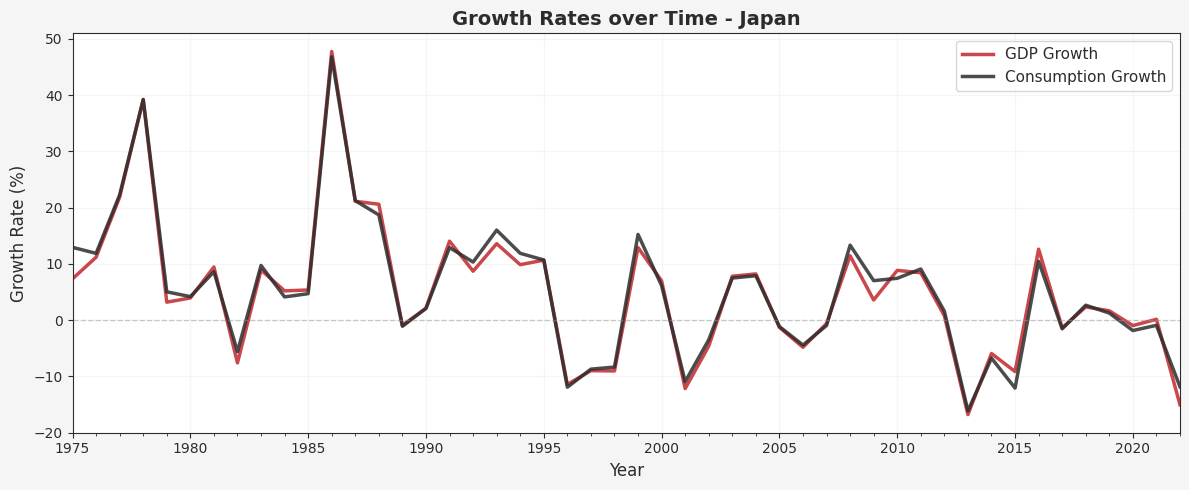

In [35]:
# Visualization of growth rates
fig,ax = plt.subplots(1,1,figsize = (12,5), facecolor = LIGHT_GREY)
df_growth.plot(ax = ax, color = [JAPAN_RED,CHARCOAL], linewidth = 2.5, alpha = 0.85)
ax.set_facecolor(JAPAN_WHITE)
ax.set_title('Growth Rates over Time - Japan', fontsize = 14, fontweight = 'bold', color = CHARCOAL)
ax.set_ylabel("Growth Rate (%)", fontsize  = 12, color = CHARCOAL)
ax.set_xlabel("Year", fontsize  = 12, color = CHARCOAL)
ax.legend(['GDP Growth','Consumption Growth'], fontsize = 11)
ax.grid(True, alpha = 0.3, color = '#E0E0E0')
ax.axhline(y = 0, color = '#999999', linestyle = '--', linewidth = 1, alpha = 0.5)
plt.tight_layout()
plt.show()

In [36]:
# Defining the ADF function to check for stationarity
def adf_test(series,name):
    result = adfuller(series, autolag = 'AIC')
    print(f'\n{name}:')
    print(f'ADF Statistic: {result[0]:0.4f}')
    print(f'p-value: {result[1]:0.4f}')
    print(f'Number of lags used: {result[2]}')
    print(f'Number of observations: {result[3]}')
    print(f'Critical Values:')
    for key,value in result[4].items():
        print(f'{key}:{value:0.4f}')

    if result[1]<= 0.05:
        print(f"Result: STATIONARY (Reject Null Hypothesis, p-value < 0.05)")
        return True
    else:
        print(f"Result: NON-STATIONARY (Fail to reject Null Hypothesis, p-value >= 0.05)")
        return False


In [37]:
# Run test for stationarity on GDP growth
gdp_stationary = adf_test(df_growth['GDP_growth'],'GDP Growth Rate')


GDP Growth Rate:
ADF Statistic: -0.6269
p-value: 0.8648
Number of lags used: 10
Number of observations: 37
Critical Values:
1%:-3.6209
5%:-2.9435
10%:-2.6104
Result: NON-STATIONARY (Fail to reject Null Hypothesis, p-value >= 0.05)


In [38]:
# Run test for stationarity on Consumption growth
consumption_stationary = adf_test(df_growth['Consumption_growth'],'Consumption Growth Rate')


Consumption Growth Rate:
ADF Statistic: -0.5241
p-value: 0.8872
Number of lags used: 10
Number of observations: 37
Critical Values:
1%:-3.6209
5%:-2.9435
10%:-2.6104
Result: NON-STATIONARY (Fail to reject Null Hypothesis, p-value >= 0.05)


In [39]:
# Handling non-staionarity
data_for_analysis = df_growth.copy()
diff_count = 0

while (not gdp_stationary or not consumption_stationary):
    diff_count +=1
    print(f"Taking difference {diff_count}")

    data_for_analysis = data_for_analysis.diff().dropna()

    print(f'Re-testing for stationarity after differencing {diff_count} time(s):')
    gdp_stationary = adf_test(data_for_analysis.iloc[:,0],f'GDP Growth (d = {diff_count})')
    consumption_stationary = adf_test(data_for_analysis.iloc[:,1],f'Consumption Growth (d = {diff_count})')

Taking difference 1
Re-testing for stationarity after differencing 1 time(s):

GDP Growth (d = 1):
ADF Statistic: -2.9831
p-value: 0.0365
Number of lags used: 9
Number of observations: 37
Critical Values:
1%:-3.6209
5%:-2.9435
10%:-2.6104
Result: STATIONARY (Reject Null Hypothesis, p-value < 0.05)

Consumption Growth (d = 1):
ADF Statistic: -3.1755
p-value: 0.0214
Number of lags used: 9
Number of observations: 37
Critical Values:
1%:-3.6209
5%:-2.9435
10%:-2.6104
Result: STATIONARY (Reject Null Hypothesis, p-value < 0.05)


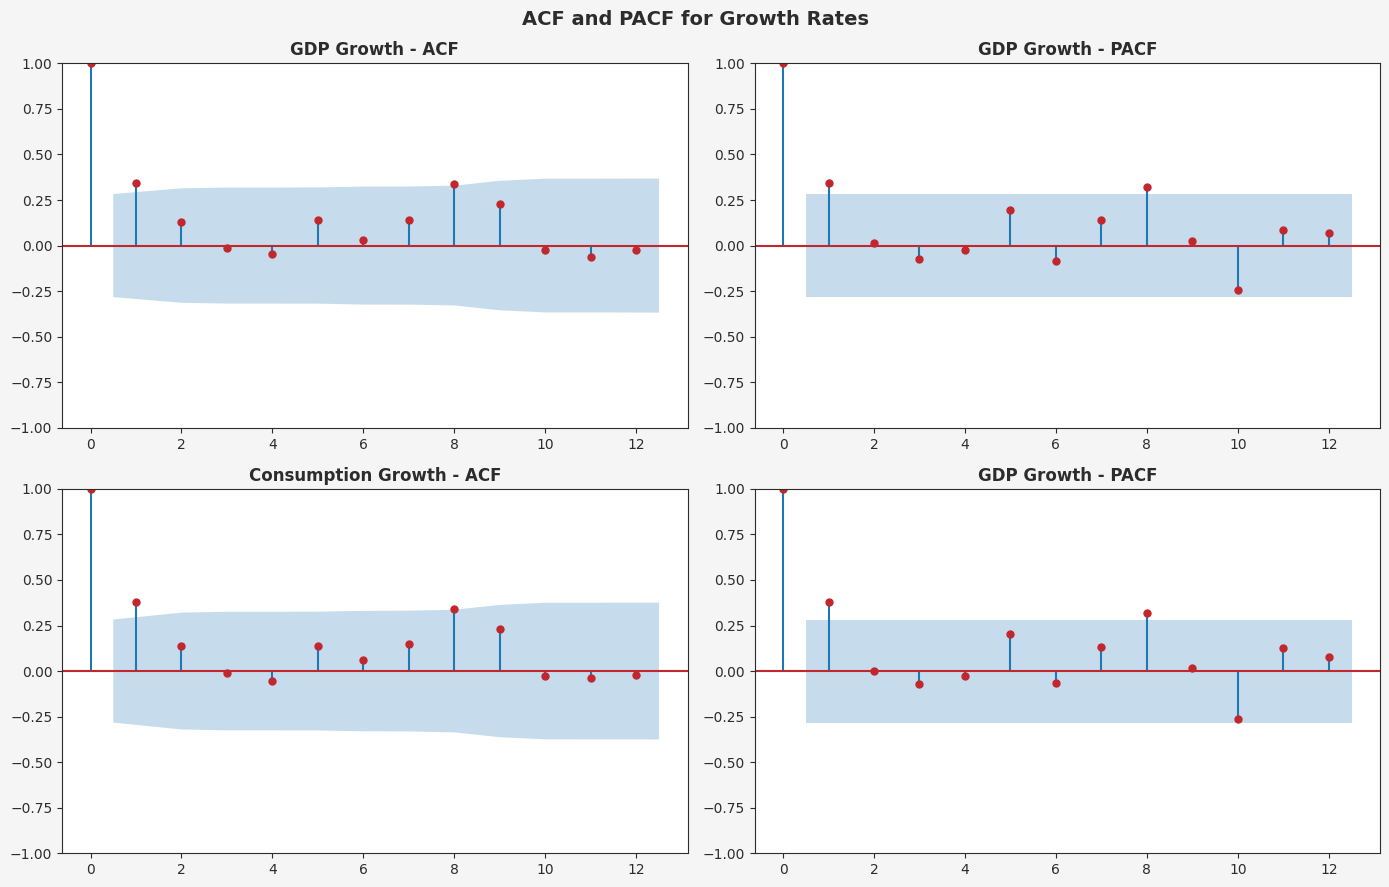

In [40]:
# Plot empirical ACF and PACF for the growth rates
fig, axes = plt.subplots(2,2,figsize = (14,9), facecolor = LIGHT_GREY)
fig.suptitle('ACF and PACF for Growth Rates', fontsize = 14, fontweight = 'bold')

max_lags = min(20,len(df_growth)/4)

plot_acf(df_growth['GDP_growth'], lags = max_lags, ax = axes[0,0], color = JAPAN_RED)
axes[0,0].set_title('GDP Growth - ACF', fontweight = 'bold')

plot_pacf(df_growth['GDP_growth'], lags = max_lags, ax = axes[0,1], color = JAPAN_RED)
axes[0,1].set_title('GDP Growth - PACF', fontweight = 'bold')

plot_acf(df_growth['Consumption_growth'], lags = max_lags, ax = axes[1,0], color = JAPAN_RED)
axes[1,0].set_title('Consumption Growth - ACF', fontweight = 'bold')

plot_pacf(df_growth['Consumption_growth'], lags = max_lags, ax = axes[1,1], color = JAPAN_RED)
axes[1,1].set_title('GDP Growth - PACF', fontweight = 'bold')

plt.tight_layout()
plt.savefig('acf_pacf_plots.png',dpi = 300, bbox_inches = 'tight')
plt.show()

In [43]:
# Estimate ARMA (p,q) for GDP growth
gdp_results = []

for p in range(5):
    for q in range (5):
        try:
            model = ARIMA(df_growth['GDP_growth'], order = (p,0,q))
            fit = model.fit()
            gdp_results.append({
                'p':p,
                'q':q,
                'AIC':fit.aic,
                'BIC':fit.bic
            }
            )
        except:
            continue

gdp_df = pd.DataFrame(gdp_results)
gdp_df = gdp_df.sort_values('AIC').reset_index(drop = True)

print("Top 10 models by AIC:")
display(gdp_df.head(10))

best_gdp_aic = gdp_df.iloc[0]
best_gdp_bic = gdp_df.sort_values('BIC').iloc[0]

print(f'\nBest model by AIC: ARMA ({int(best_gdp_aic['p'])},{int(best_gdp_aic['q'])})')
print(f"AIC: {best_gdp_aic['AIC']:.2f}, BIC: {best_gdp_aic['BIC']:.2f}")

print(f'\nBest model by BIC: ARMA ({int(best_gdp_bic['p'])},{int(best_gdp_bic['q'])})')
print(f"AIC: {best_gdp_bic['AIC']:.2f}, BIC: {best_gdp_bic['BIC']:.2f}")

Top 10 models by AIC:


,p,q,AIC,BIC
0,2,2,372.785202,384.012408
1,0,4,374.123179,385.350385
2,1,4,374.290673,387.389080
3,3,2,374.673976,387.772384
4,2,3,374.726746,387.825153
5,2,4,375.063056,390.032664
6,1,0,375.573041,381.186644
7,3,3,375.680655,390.650263
8,0,1,376.448404,382.062007
9,4,2,376.676800,391.646408



Best model by AIC: ARMA (2,2)
AIC: 372.79, BIC: 384.01

Best model by BIC: ARMA (1,0)
AIC: 375.57, BIC: 381.19


In [44]:
# Estimate ARMA (p,q) for Consumption growth
consumption_results = []

for p in range(5):
    for q in range (5):
        try:
            model = ARIMA(df_growth['Consumption_growth'], order = (p,0,q))
            fit = model.fit()
            consumption_results.append({
                'p':p,
                'q':q,
                'AIC':fit.aic,
                'BIC':fit.bic
            }
            )
        except:
            continue

consumption_df = pd.DataFrame(consumption_results)
consumption_df = consumption_df.sort_values('AIC').reset_index(drop = True)

print("Top 10 models by AIC:")
display(consumption_df.head(10))

best_consumption_aic = consumption_df.iloc[0]
best_consumption_bic = consumption_df.sort_values('BIC').iloc[0]

print(f'\nBest model by AIC: ARMA ({int(best_consumption_aic['p'])},{int(best_consumption_aic['q'])})')
print(f"AIC: {best_consumption_aic['AIC']:.2f}, BIC: {best_consumption_aic['BIC']:.2f}")

print(f'\nBest model by BIC: ARMA ({int(best_consumption_bic['p'])},{int(best_consumption_bic['q'])})')
print(f"AIC: {best_consumption_bic['AIC']:.2f}, BIC: {best_consumption_bic['BIC']:.2f}")

Top 10 models by AIC:


,p,q,AIC,BIC
0,2,4,369.397302,384.366911
1,2,2,369.886537,381.113743
2,0,4,370.366514,381.593720
3,1,4,370.483140,383.581547
4,3,2,371.737197,384.835604
5,3,3,372.486986,387.456594
6,1,0,373.544049,379.157652
7,4,2,373.623372,388.592980
8,4,4,374.042499,392.754509
9,3,4,374.233978,391.074787



Best model by AIC: ARMA (2,4)
AIC: 369.40, BIC: 384.37

Best model by BIC: ARMA (1,0)
AIC: 373.54, BIC: 379.16


In [45]:
# VAR Model Selection
var_results = []

for p in range(5):
    if p == 0:
        continue #VAR(0) is not meaningful)
    try:
        model = VAR(data_for_analysis)
        fit = model.fit(p)
        var_results.append({
            'p':p,
            'AIC':fit.aic,
            'BIC':fit.bic,
            'FPE':fit.fpe,
            'HQIC':fit.hqic
        })
    
    except:
        continue

var_df = pd.DataFrame(var_results)
print("VAR Model Comparison:")
display(var_df)

best_var_aic = var_df.sort_values("AIC").iloc[0]
best_var_bic = var_df.sort_values("BIC").iloc[0]

print(f"Best model by AIC: VAR({int(best_var_aic['p'])})")
print(f'AIC: {best_var_aic['AIC']:0.2f}, BIC: {best_var_aic['BIC']:0.2f}')

print(f"Best model by BIC: VAR({int(best_var_bic['p'])})")
print(f'AIC: {best_var_bic['AIC']:0.2f}, BIC: {best_var_bic['BIC']:0.2f}')

# Fit the best model
optimal_p = int(best_var_aic['p'])
var_model = VAR(data_for_analysis).fit(optimal_p)

VAR Model Comparison:


,p,AIC,BIC,FPE,HQIC
0,1,6.279195,6.517714,533.556976,6.368546
1,2,6.238878,6.640358,513.228084,6.388546
2,3,6.214475,6.782172,502.666442,6.425004
3,4,6.225123,6.962370,511.670119,6.496997


Best model by AIC: VAR(3)
AIC: 6.21, BIC: 6.78
Best model by BIC: VAR(1)
AIC: 6.28, BIC: 6.52


In [46]:
# Granger Causality Test

max_lag = min(4, len(data_for_analysis)//3)

# Does Consumption Granger-cause GDP?

gc_cons_to_gdp = grangercausalitytests(
    data_for_analysis[['GDP_growth','Consumption_growth']],
    maxlag = max_lag,
    verbose = True
) 

# Does GDP Granger-cause Consumption?

gc_gdp_to_cons = grangercausalitytests(
    data_for_analysis[['Consumption_growth','GDP_growth']],
    maxlag = max_lag,
    verbose = True
)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1127  , p=0.7387  , df_denom=43, df_num=1
ssr based chi2 test:   chi2=0.1206  , p=0.7284  , df=1
likelihood ratio test: chi2=0.1204  , p=0.7286  , df=1
parameter F test:         F=0.1127  , p=0.7387  , df_denom=43, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8569  , p=0.4321  , df_denom=40, df_num=2
ssr based chi2 test:   chi2=1.9281  , p=0.3813  , df=2
likelihood ratio test: chi2=1.8880  , p=0.3891  , df=2
parameter F test:         F=0.8569  , p=0.4321  , df_denom=40, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7333  , p=0.5388  , df_denom=37, df_num=3
ssr based chi2 test:   chi2=2.6162  , p=0.4547  , df=3
likelihood ratio test: chi2=2.5414  , p=0.4679  , df=3
parameter F test:         F=0.7333  , p=0.5388  , df_denom=37, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.2337  , p=0.9174  , df_d

In [47]:
# Interpretation of Granger-causality tests

# Extract p-values from test results

# Test 1: Consumption to GDP

cons_to_gdp_pvalues = []
for lag in range(1, max_lag+1):
    pvalue = gc_cons_to_gdp[lag][0]['ssr_ftest'][1]
    cons_to_gdp_pvalues.append((lag,pvalue))

# Test 2: GDP to Consumption

gdp_to_cons_pvalues = []
for lag in range(1, max_lag+1):
    pvalue = gc_gdp_to_cons[lag][0]['ssr_ftest'][1]
    gdp_to_cons_pvalues.append((lag,pvalue))

print("\nConsumption to GDP:")
for lag, pval in cons_to_gdp_pvalues:
    result = "Yes (p < 0.05)" if pval < 0.05 else "No (p >= 0.05)"
    print(f"  Lag {lag}: p-value = {pval:.4f} - Granger causality: {result}")

print("\nGDP to Consumption:")
for lag, pval in gdp_to_cons_pvalues:
    result = "Yes (p < 0.05)" if pval < 0.05 else "No (p >= 0.05)"
    print(f"  Lag {lag}: p-value = {pval:.4f} - Granger causality: {result}")

cons_causes_gdp = any(pval < 0.05 for _, pval in cons_to_gdp_pvalues)
gdp_causes_cons = any(pval < 0.05 for _, pval in gdp_to_cons_pvalues)

if cons_causes_gdp:
    cons_lags = [lag for lag, pval in cons_to_gdp_pvalues if pval < 0.05]
    print(f"Consumption Granger-causes GDP at lag(s): {cons_lags}")
else:
    print("Consumption does NOT Granger-cause GDP")

if gdp_causes_cons:
    gdp_lags = [lag for lag, pval in gdp_to_cons_pvalues if pval < 0.05]
    print(f"GDP Granger-causes Consumption at lag(s): {gdp_lags}")
else:
    print("GDP does NOT Granger-cause Consumption")


Consumption to GDP:
  Lag 1: p-value = 0.7387 - Granger causality: No (p >= 0.05)
  Lag 2: p-value = 0.4321 - Granger causality: No (p >= 0.05)
  Lag 3: p-value = 0.5388 - Granger causality: No (p >= 0.05)
  Lag 4: p-value = 0.9174 - Granger causality: No (p >= 0.05)

GDP to Consumption:
  Lag 1: p-value = 0.6722 - Granger causality: No (p >= 0.05)
  Lag 2: p-value = 0.3693 - Granger causality: No (p >= 0.05)
  Lag 3: p-value = 0.5355 - Granger causality: No (p >= 0.05)
  Lag 4: p-value = 0.9469 - Granger causality: No (p >= 0.05)
Consumption does NOT Granger-cause GDP
GDP does NOT Granger-cause Consumption
